In [1]:
import cv2 as cv
import numpy as np
import os

import matplotlib.pyplot as plt


In [2]:
def load_images_from_folder(folder):
    images = []
    files = sorted(os.listdir(folder))
    for filename in files:
        img = cv.imread(os.path.join(folder,filename), cv.CV_8UC3)
        if img is not None:
            if len(img.shape) == 2:
                img = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
                
            while img.shape[1] > 2 * 600:
                img = cv.pyrDown(img)
            images.append(img)
    return images

In [3]:
len(load_images_from_folder('images/entry-P10'))

10

In [4]:
def load_K_from_folder(folder):
    K = []
    d = np.array([0.0, 0.0, 0.0, 0.0, 0.0]).reshape(1, 5)
    for filename in os.listdir(folder):
        if ".txt" in filename:
            f = open(f"{folder}/{filename}", 'r')
            par = f.read().splitlines()
            for p in par:
                r = p.split(" ")
                K.append(r[:3])
    return np.array(K, dtype=np.float64), d

In [5]:
load_K_from_folder('images/entry-P10')

(array([[2.75948e+03, 0.00000e+00, 1.52069e+03],
        [0.00000e+00, 2.76416e+03, 1.00681e+03],
        [0.00000e+00, 0.00000e+00, 1.00000e+00]]),
 array([[0., 0., 0., 0., 0.]]))

In [6]:
def image_pair(img1, img2, K, d):
    return [cv.undistort(img, K, d) for img in (img1, img2)]

In [7]:
PATH = 'images/fountain-P11'

images_raw = load_images_from_folder(PATH)
K, d = load_K_from_folder(PATH)

# image_pair(images_raw[0], images_raw[1], K, d)

In [8]:
def extract_keypoints_sift(images):
    sift = cv.SIFT_create()
    kp1, ds1 = sift.detectAndCompute(images[0], None)
    kp2, ds2 = sift.detectAndCompute(images[1], None)
    return [(kp1, ds1), (kp2, ds2)]

In [9]:
# extract_keypoints_sift(image_pair(images_raw[0], images_raw[1], K, d))

In [10]:
def feature_matching_bf(img_kp_ds):
    img1, img2 = img_kp_ds[0], img_kp_ds[1]
    kp1, ds1 = img1
    kp2, ds2 = img2
    
    bf = cv.BFMatcher(cv.NORM_L1, True)
    matches = bf.match(ds1, ds2)
    
    match_pts1 = np.array([kp1[match.queryIdx].pt for match in matches])
    match_pts2 = np.array([kp2[match.trainIdx].pt for match in matches])
    
    return matches, (match_pts1, match_pts2)

In [11]:
def plot_matches(img1, img2, kp1, kp2, matched_pts):    
    plotted_imgs = []
    plotted_imgs.append(cv.drawMatches(img1, kp1, img2, kp2, matched_pts[10:], None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS))
    return plotted_imgs

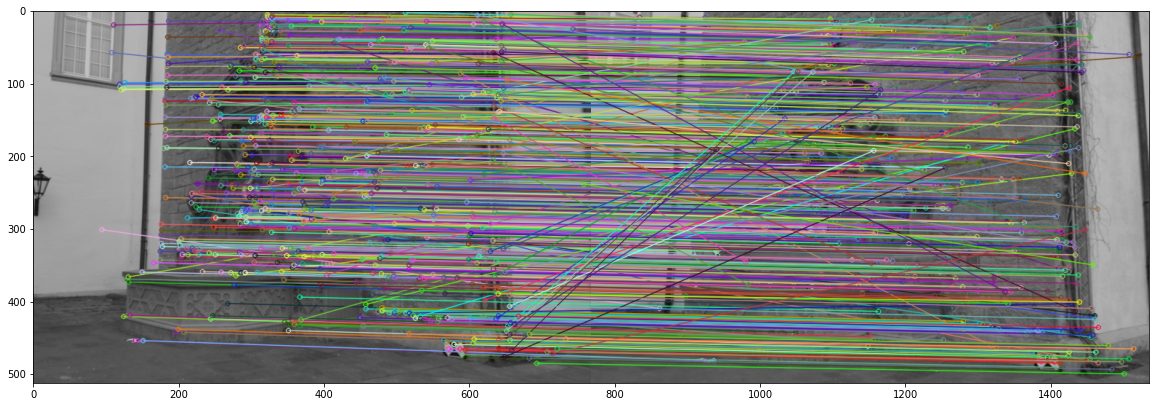

In [12]:
imgs_raw = load_images_from_folder(PATH)

kps_des = extract_keypoints_sift(image_pair(imgs_raw[0], imgs_raw[1], K, d))
d_matches, matched_points = feature_matching_bf(kps_des)
matched_img = plot_matches(imgs_raw[0], imgs_raw[1], kps_des[0][0], kps_des[1][0], d_matches)

plt.figure(figsize=(20, 12))
plt.imshow(matched_img[0])
plt.show()

In [13]:
def find_F_mat(matched_pts1, matched_pts2):
    F, mask = cv.findFundamentalMat(matched_pts1, matched_pts2, cv.FM_RANSAC, 0.1, 0.99)
    return F, mask

In [14]:
def find_E_mat(K, F):
    return K.T.dot(F).dot(K)

In [15]:
def transform_2d_to_3d_homogeneous(pts1, pts2, F_mask, K):
    new_p1 = []
    new_p2 = []
    K_inv = np.linalg.inv(K)
    
    for p1, p2, mask in zip(pts1, pts2, F_mask):
        if mask:
            new_p1.append(K_inv.dot([p1[0], p1[1], 1.0]))
            new_p2.append(K_inv.dot([p2[0], p2[1], 1.0]))
    return (np.array(new_p1), np.array(new_p2))

In [16]:
def in_front_of_both_cams(pts1, pts2, R, t):
    """
    Determines whether point correspondences are in front of bothimages
    """
    rot_inv = R
    for first, second in zip(pts1, pts2):
        first_z = np.dot(R[0, :] - second[0] * R[2, :], t) / np.dot(R[0, :] - second[0] * R[2,:], second)
        first_3d_point = np.array([first[0] * first_z, second[0] * first_z, first_z])
        second_3d_point = np.dot(R.T, first_3d_point) - np.dot(R.T, t)
        
        if first_3d_point[2] < 0 or second_3d_point[2] < 0:
            return False
    return True

In [17]:
def find_camera_mats(E, pts1, pts2):
    U, S, Vt = np.linalg.svd(E)
    W = np.array([0.0, -1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0]).reshape(3, 3)
    
    R = T = None
    R = U.dot(W.T).dot(Vt)
    T = U[:, 2]
    for r in (U.dot(W).dot(Vt), U.dot(W.T).dot(Vt)):
        for t in (U[:, 2], -U[:, 2]):
            if in_front_of_both_cams(pts1, pts2, r, t):
                R, T = r, t
                
    assert R is not None, "Camera matricies were never found!"
    
    Rt1 = np.hstack((np.eye(3), np.zeros((3, 1))))
    Rt2 = np.hstack((R, T.reshape(3, 1)))
    return Rt1, Rt2

In [18]:
def plot_rectified_images(img1, img2):
    K, d = load_K_from_folder(PATH)
    
    K = np.array([[2759.48 / 4, 0, 1520.69 / 4, 0, 2764.16 / 4, 1006.81 / 4, 0, 0, 1]]).reshape(3, 3)

    kps_des = extract_keypoints_sift(image_pair(img1, img2, K, d))
    _, matched_points = feature_matching_bf(kps_des)

    F, mask = find_F_mat(matched_points[0], matched_points[1])
    pts1_3d, pts2_3d = transform_2d_to_3d_homogeneous(matched_points[0], matched_points[1], mask, K)

    E = find_E_mat(K, F)

    Rt1, Rt2 = find_camera_mats(E, pts1_3d, pts2_3d)
    
    R = Rt2[:, :3]
    T = Rt2[:, 3]
    
    print(K)
    print(F)
    
    
    R1, R2, P1, P2, Q, roi1, roi2 = cv.stereoRectify(K, d, K, d, img1.shape[:2], R, T, alpha=1.0)
    
    
    mapx1, mapy1 = cv.initUndistortRectifyMap(K, d, R1, K, img1.shape[:2], cv.CV_32F)
    mapx2, mapy2 = cv.initUndistortRectifyMap(K, d, R2, K, img2.shape[:2], cv.CV_32F)
    
#     print(mapx1, mapx2)
#     print(mapy1, mapy2)
    
    img_rect1 = cv.remap(img1, mapx1, mapy1, cv.INTER_LINEAR)
    img_rect2 = cv.remap(img2, mapx2, mapy2, cv.INTER_LINEAR)
    
    
    # draw the images side by side
    total_size = (max(img_rect1.shape[0], img_rect2.shape[0]), img_rect1.shape[1] + img_rect2.shape[1], 3)
    img = np.zeros(total_size, dtype=np.uint8)
    img[:img_rect1.shape[0], :img_rect1.shape[1]] = img_rect1
    img[:img_rect2.shape[0], img_rect1.shape[1]:] = img_rect2
    

    # draw horizontal lines every 25 px accross the side by side image
    for i in range(20, img.shape[0], 25):
        cv.line(img, (0, i), (img.shape[1], i), (255, 0, 0))

    return img

In [19]:
# imgs_raw = load_images_from_folder(PATH)
# K, d = load_K_from_folder(PATH)

# kps_des = extract_keypoints_sift(image_pair(imgs_raw[0], imgs_raw[1], K, d))
# _, matched_points = feature_matching_bf(kps_des)

# F, mask = find_F_mat(matched_points[0], matched_points[1])
# pts1_3d, pts2_3d = transform_2d_to_3d_homogeneous(matched_points[0], matched_points[1], mask, K)

# E = find_E_mat(K, F)

[[689.87     0.     380.1725]
 [  0.     691.04   251.7025]
 [  0.       0.       1.    ]]
[[-1.22601100e-07 -1.02081001e-06 -8.93338646e-05]
 [ 7.55540279e-06  4.46054972e-07  1.97481485e-02]
 [-1.61602994e-03 -2.30050783e-02  1.00000000e+00]]


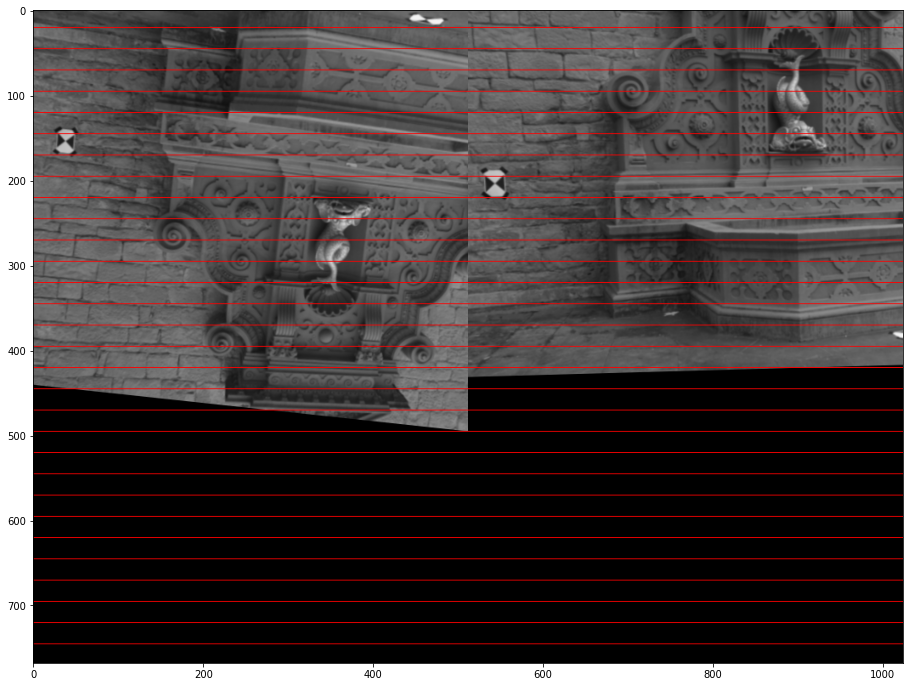

In [20]:
imgs_raw = load_images_from_folder(PATH)
K, d = load_K_from_folder(PATH)

kps_des = extract_keypoints_sift(image_pair(imgs_raw[0], imgs_raw[1], K, d))
_, matched_points = feature_matching_bf(kps_des)

F, mask = find_F_mat(matched_points[0], matched_points[1])
pts1_3d, pts2_3d = transform_2d_to_3d_homogeneous(matched_points[0], matched_points[1], mask, K)

E = find_E_mat(K, F)

Rt1, Rt2 = find_camera_mats(E, pts1_3d, pts2_3d)

img = plot_rectified_images(imgs_raw[6], imgs_raw[7])
plt.figure(figsize=(20, 12))
plt.imshow(img)
plt.show()

In [2]:
import json
import numpy as np

def read_points_3d(name):
    file = open(f"../c++/points-3d_pairs/{name}")
    data = json.load(file)
    res = np.reshape(data["points_3d"]["data"], (-1, 3))
    return res

points = []

for i in range(10):
    points.append(read_points_3d(f"{i}-{i+1}.json"))

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Enable interactive mode (only in Jupyter Notebook or Jupyter Lab)
%matplotlib notebook

points = []
# file = open(f"../c++/points-3d_pairs/33-34.json")
# data = json.load(file)
# res = np.reshape(data["points_3d"]["data"], (-1, 3))
# points.append(res)

points.append(read_points_3d(f"88-89.json"))
# points.append(read_points_3d(f"46-47.json"))


# print(len())

# Create a figure and a 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = []
y = []
z = []

for pts in points[:1]:
    for x_pt, y_pt, z_pt in pts:
        if (-150 < x_pt <100) and (-150 < y_pt <100) and (-150 < z_pt <100):
            x.append(x_pt)
            y.append(y_pt)
            z.append(z_pt)

x = np.array(x)
y = np.array(y)
z = np.array(z)

print(len(x))

# Create a 3D scatter plot
# ax.scatter(x_r1t1, y_r1t1, z_r1t1, c='r', marker='o')
ax.scatter(x, y, z, c=z, marker='o', s=8)



# Set the title
ax.set_title('Interactive 3D Plot')

# Show the plot
plt.show()

<IPython.core.display.Javascript object>

687
